In [1]:
!pip install optuna
#!pip install catboost

     |████████████████████████████████| 296kB 13.9MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 174kB 26.9MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 112kB 24.0MB/s 
     |████████████████████████████████| 143kB 23.3MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=145e8fd7e2b8fcbf894d0f47100928bd3e334d012c69c9e7063770fb4f81a380
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier,LGBMRegressor
import lightgbm as lgbm
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier,XGBRegressor
#from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import cross_val_score,StratifiedKFold,train_test_split,KFold
import warnings
warnings.filterwarnings('ignore')

In [3]:
!unzip "/content/prml-data-contest-jan-2021.zip"

Archive:  /content/prml-data-contest-jan-2021.zip
  inflating: prml-data-contest-jan-2021/dummy_submission.csv  
  inflating: prml-data-contest-jan-2021/save_for_later.csv  
  inflating: prml-data-contest-jan-2021/song_labels.csv  
  inflating: prml-data-contest-jan-2021/songs.csv  
  inflating: prml-data-contest-jan-2021/test.csv  
  inflating: prml-data-contest-jan-2021/train.csv  


In [4]:

dir='/content/prml-data-contest-jan-2021'
train_path=dir+'/train.csv'
test_path=dir+'/test.csv'
dummy=dir+'/dummy_submission.csv'
save=dir+'/save_for_later.csv'
s_labels=dir+'/song_labels.csv'
so=dir+'/songs.csv'

train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
sub=pd.read_csv(dummy)
songs=pd.read_csv(so)
song_labels=pd.read_csv(s_labels)
song_labels=song_labels.loc[song_labels.groupby(['platform_id'])['count'].idxmax()]
save_for_later=pd.read_csv(save)

In [ ]:
song_labels.head()

,platform_id,label_id,count
522972,P10,30574,3226
502330,P10090,30574,3005
42661,P102030,30574,11049
382884,P10210,30574,6084
954569,P1025250,30574,6583


In [5]:
save_for_later['Saved']=1


In [ ]:
song_labels

,platform_id,label_id,count
522972,P10,30574,3226
502330,P10090,30574,3005
42661,P102030,30574,11049
382884,P10210,30574,6084
954569,P1025250,30574,6583
...,...,...,...
429449,Y9917879,30574,8815
944038,Y99219,30574,4199
841502,Y99329,30574,22374
242929,Y9975679,30574,29954


In [6]:
train_merged=pd.merge(train,songs,on='song_id',how='left')
train_merged

,customer_id,song_id,score,platform_id,released_year,language,number_of_comments
0,O29219,3459,3,P49540,1782.0,eng,1066.0
1,I50343,5326,4,W216377,1981.0,eng,1119.0
2,N42888,236,5,X1898,1997.0,en-US,10439.0
3,F5740,724,4,W2233407,2008.0,eng,3500.0
4,K4115,8452,5,V5946,1987.0,NaN,762.0
...,...,...,...,...,...,...,...
710104,H6322,1003,4,V61666,1985.0,eng,2126.0
710105,L6306,705,5,U10605,1984.0,en-GB,1641.0
710106,J2494,6028,3,Y9509289,2011.0,en-US,2542.0
710107,G41961,2397,4,W76237,1985.0,NaN,36.0


In [7]:

#save_for_later['Saved']=1
#train_merged=pd.merge(train,songs,on='song_id',how='left')
train_merged=pd.merge(train_merged,song_labels,on='platform_id',how='left')
test_merged=pd.merge(test,songs,on='song_id',how='left')
test_merged=pd.merge(test_merged,song_labels,on='platform_id',how='left')
train_merged['Saved']=0
test_merged['Saved']=0
dat=pd.concat([train_merged,test_merged])
dat_m=pd.merge(dat,save_for_later,how='left',on=['customer_id','song_id'])
dat_m['Saved']=(dat_m['Saved_y'].fillna(0)+dat_m['Saved_x']).apply(lambda x:int(x))
dat_m.drop(['Saved_x','Saved_y'],axis=1,inplace=True)
#dat_m.loc[dat_m['language']=='en-US','language']='eng'
#dat_m.loc[dat_m['language']=='en-CA','language']='eng'
#dat_m.loc[dat_m['language']=='en-GB','language']='eng'

In [8]:
dat_m.head()

,customer_id,song_id,score,platform_id,released_year,language,number_of_comments,label_id,count,Saved
0,O29219,3459,3.0,P49540,1782.0,eng,1066.0,30574.0,31952.0,0
1,I50343,5326,4.0,W216377,1981.0,eng,1119.0,30574.0,14338.0,0
2,N42888,236,5.0,X1898,1997.0,en-US,10439.0,30574.0,21613.0,0
3,F5740,724,4.0,W2233407,2008.0,eng,3500.0,30574.0,22397.0,0
4,K4115,8452,5.0,V5946,1987.0,NaN,762.0,30574.0,5715.0,0


## Preprocessing

In [ ]:
#dat_m['released_year'].fillna(0,inplace=True)
#dat_m['platform_id'].fillna(dat_m['platform_id'].mode()[0],inplace=True)
#dat_m['language'].fillna(dat_m['language'].mode()[0],inplace=True)
#dat_m['number_of_comments'].fillna(0,inplace=True)
#dat_m['count'].fillna(0,inplace=True)
#dat_m['label_id'].fillna(0,inplace=True)

In [9]:
#cols=['customer_id','platform_id', 'language']
cols=['customer_id','song_id','platform_id','language','label_id']
for col in cols:
  enc=LabelEncoder()
  dat_m[col]=enc.fit_transform(dat_m[col].astype(str))
cols=['number_of_comments','count']
for col in cols:
  imp=KNNImputer(n_neighbors=15)
  dat_m[col]=imp.fit_transform(dat_m[[col]])
train_new=dat_m.iloc[:len(train)]
test_new=dat_m.iloc[len(train):]
test_new.drop(['score'],axis=1,inplace=True)

In [10]:
train_new.to_csv('train_new_proper.csv',index=False)
test_new.to_csv('test_new_proper.csv',index=False)

In [ ]:
train_new=pd.read_csv('train_new.csv')
test_new=pd.read_csv('test_new.csv')

customer_id              0
song_id                  0
score                    0
platform_id              0
released_year         1527
language                 0
number_of_comments       0
label_id                 0
count                    0
Saved                    0
dtype: int64

## Training

In [11]:
X,y=train_new.drop(['score'],axis=1),train_new['score']
scorer=make_scorer(mean_squared_error)
fold=KFold(n_splits=6,random_state=101)

In [12]:
X

,customer_id,song_id,platform_id,released_year,language,number_of_comments,label_id,count,Saved
0,13168,2734,698,1782.0,6,1066.0,59,31952.0,0
1,5393,4809,7389,1981.0,6,1119.0,59,14338.0,0
2,12189,1513,8333,1997.0,5,10439.0,59,21613.0,0
3,1306,6935,7405,2008.0,6,3500.0,59,22397.0,0
4,7967,8282,6767,1987.0,14,762.0,59,5715.0,0
...,...,...,...,...,...,...,...,...,...
710104,4097,7,6780,1985.0,6,2126.0,59,57469.0,0
710105,9781,6724,5010,1984.0,4,1641.0,16,2687.0,0
710106,6035,5589,9960,2011.0,5,2542.0,59,3502.0,0
710107,2340,1554,7853,1985.0,14,36.0,59,2169.0,0


In [13]:
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=100,test_size=0.3)

In [ ]:
#params={'lambda_l1': 1.856734106912951e-06, 'lambda_l2': 3.686049110509207e-05, 'num_leaves': 179, 'feature_fraction': 0.6392889819168043, 'bagging_fraction': 0.901838979740169, 'bagging_freq': 3, 'min_child_samples': 11}

In [ ]:
model=LGBMRegressor(objective='regression',**params2,random_state=101)
model.fit(X_train,y_train,categorical_feature=['customer_id','song_id','platform_id','language','label_id','Saved'])
p=model.predict(X_val)
p1=np.clip(p,1,5)
print(mean_squared_error(y_val,p1))

0.9340695506814357


In [ ]:
model1=LGBMRegressor(objective='regression',**params2,categorical_feature=['customer_id','song_id','platform_id','language','label_id','Saved'])
model2=LGBMRegressor(objective='regression',**params,categorical_feature=['customer_id','song_id','platform_id','language','label_id','Saved'])
models=[('lgbm1',model1),('lgbm2',model2)]
model=StackingRegressor(models,final_estimator=LGBMRegressor())
fit_params={'categorical_feature':['customer_id','song_id','platform_id','language','label_id','Saved']}
y=model.fit(X_train,y_train)
p=model.predict(X_val)
p1=np.clip(p,1,5)
print(mean_squared_error(y_val,p1))

NameError: ignored

In [ ]:
params={'reg_alpha': 0.009820865971871366, 'reg_lambda': 3.188178573374264, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 100, 'num_leaves': 687, 'min_child_samples': 98}

In [ ]:

vals=cross_val_score(LGBMRegressor(**params2,random_state=101,objective='regression',subsample_freq=1,min_data_per_group=1),X,y,n_jobs=-1,cv=fold,scoring=scorer,fit_params={'categorical_feature':['customer_id','song_id','platform_id','language','label_id','Saved']})

In [ ]:
vals

array([0.74373964, 0.73677885, 0.74342921, 0.74031572, 0.73714526])

In [ ]:
vals.mean()

0.7402817344015269

In [ ]:
preds,models=[],[]
for train_idx,test_idx in fold.split(X,y):
  X_train,y_train=X.iloc[train_idx],y[train_idx]
  X_val,y_val=X.iloc[test_idx],y[test_idx]
  model=LGBMRegressor(objective='regression',**params2,random_state=101,subsample_freq=1)
  model.fit(X_train,y_train,categorical_feature=['customer_id','song_id','platform_id','language','label_id','Saved'])
  models.append(model)
p1=np.zeros(len(test_new))
for model in models:
  p=model.predict(test_new)
  p1+=p
preds=p1/5
preds=np.clip(preds,1,5)

KeyboardInterrupt: ignored

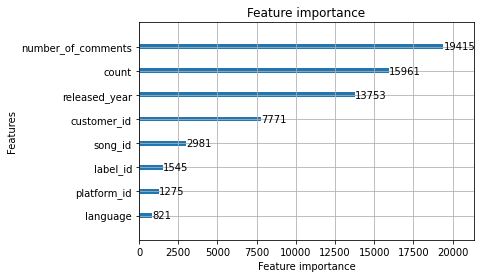

In [ ]:
lgbm.plot_importance(model)

In [ ]:
len(preds)

670681

In [ ]:
sub['score']=preds
sub.to_csv('Pred8.csv',index=False)

## Tuning

In [ ]:
import optuna
from optuna import trial
def objective(trial:optuna.trial.Trial):
  param = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric': 'mse', 
        'random_state': 101,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1,0.2,0.4,0.5]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,30, 40, 50,100,128]),
        'num_iterations': trial.suggest_categorical('num_iterations', [200,300, 400, 500,600,700, 800, 1000]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'subsample_freq':1,
        'num_thread':2,
        'verbose' : 50}

  #param = {
  #  'objective': 'regression',
  #  'metric': 'mse',
  #  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
  #  'n_estimators':trial.suggest_int('n_estimators',128,512),
  #  'num_leaves': trial.suggest_int('num_leaves', 2, 256),
  #  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
  #  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
  #  'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
  #  'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
  #}
  #param = {
  #    'iterations' : trial.suggest_int('iterations', 50, 300),                         
  #    'depth' : trial.suggest_int('depth', 4, 10),                                       
  #    'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
  #    'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
  #    'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
  #    'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
  #    'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
  #}
  X,y=train_new.drop(['score'],axis=1),train_new['score']
  X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=101,test_size=0.3)
  scorer=make_scorer(mean_squared_error)
  fold=KFold(n_splits=5,random_state=101) 
  lgbm = LGBMRegressor(**param)
  scorer=make_scorer(mean_squared_error)
  #score = cross_val_score(LGBMRegressor(**params), X, y, verbose=1,n_jobs=-1, scoring=scorer, cv=fold,fit_params={'categorical_feature':['customer_id','song_id','platform_id','language','label_id','Saved']})
  lgbm.fit(X_train,y_train,categorical_feature=['customer_id','song_id','platform_id','language','label_id','Saved'],  verbose = 50)
  p=lgbm.predict(X_val)
  p=np.clip(p,1,5)
  score=mean_squared_error(y_val,p)
  return score


studies = optuna.create_study(direction='minimize')
studies.optimize(objective, n_trials=100)

print(studies.best_value)
print(studies.best_params)

[I 2021-05-30 09:56:02,185] A new study created in memory with name: no-name-7bd32cd0-8ee9-46df-bfa1-33dcbdbd4e31
[I 2021-05-30 09:57:28,677] Trial 0 finished with value: 0.765809955762764 and parameters: {'reg_alpha': 0.16491598342145844, 'reg_lambda': 0.002318788235860498, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.1, 'max_depth': 10, 'num_iterations': 800, 'num_leaves': 695, 'min_child_samples': 47}. Best is trial 0 with value: 0.765809955762764.
[I 2021-05-30 09:58:13,399] Trial 1 finished with value: 0.7553665887238046 and parameters: {'reg_alpha': 0.014062306041603344, 'reg_lambda': 3.299358160657055, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 30, 'num_iterations': 200, 'num_leaves': 984, 'min_child_samples': 192}. Best is trial 1 with value: 0.7553665887238046.
[I 2021-05-30 10:02:01,326] Trial 2 finished with value: 0.7516201836514765 and parameters: {'reg_alpha': 0.06364819045745623, 'reg_lambda': 0.007643434964541315, 'col

In [ ]:
optuna.visualization.plot_param_importances(studies)

In [ ]:
'lambda_l1': 5.220574643186443, 'lambda_l2': 2.2037247231276307e-05, 'num_leaves': 245, 'feature_fraction': 0.40220174225040056, 'bagging_fraction': 0.9918520487946106, 'bagging_freq': 1, 'min_child_samples': 22

In [ ]:
params2={'reg_alpha': 0.8695646157740582, 'reg_lambda': 0.04000656260214025, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 100, 'num_leaves': 758, 'min_child_samples': 96}